# 02 – Baseline (TF-IDF + Logistic Regression)

Ziel: Ein klassisches ML-Baseline-Modell trainieren, um später den Mehrwert von BERT (Deep Learning) zu quantifizieren.


In [1]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## 1) CSV laden


In [2]:
PROJECT_ROOT = Path.cwd().parent
CSV_PATH = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8")
df.shape, df["label"].nunique()



((2225, 5), 5)

In [3]:
df.head(2)


,id,label,text,source_file,n_chars
0,1,business,Ad sales boost Time Warner profit\n\nQuarterly...,data\raw\bbc\business\001.txt,2559
1,2,business,Dollar gains on Greenspan speech\n\nThe dollar...,data\raw\bbc\business\002.txt,2252


## 2) Train/Test Split


In [4]:
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train label dist:\n", y_train.value_counts(normalize=True).round(3))
print("Test label dist:\n", y_test.value_counts(normalize=True).round(3))


Train: (1780,) Test: (445,)
Train label dist:
 label
sport            0.230
business         0.229
politics         0.187
tech             0.180
entertainment    0.174
Name: proportion, dtype: float64
Test label dist:
 label
business         0.229
sport            0.229
politics         0.189
tech             0.180
entertainment    0.173
Name: proportion, dtype: float64


## 3) Baseline Modell: TF-IDF + Logistic Regression


In [5]:
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        max_features=50000
    )),
    ("logreg", LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        class_weight=None
    ))
])
baseline_clf


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg', LogisticRegression(max_iter=2000, n_jobs=-1))])

In [6]:
baseline_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg', LogisticRegression(max_iter=2000, n_jobs=-1))])

## 4) Evaluation


In [7]:
y_pred = baseline_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 4))


Accuracy: 0.991


In [8]:
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

     business       1.00      0.97      0.99       102
entertainment       1.00      1.00      1.00        77
     politics       0.99      0.99      0.99        84
        sport       0.99      1.00      1.00       102
         tech       0.98      1.00      0.99        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



## Confusion Matrix (Baseline-Modell)


In [9]:
import numpy as np

labels_sorted = sorted(df["label"].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

cm_df = pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted)
cm_df


,business,entertainment,politics,sport,tech
business,99,0,1,1,1
entertainment,0,77,0,0,0
politics,0,0,83,0,1
sport,0,0,0,102,0
tech,0,0,0,0,80


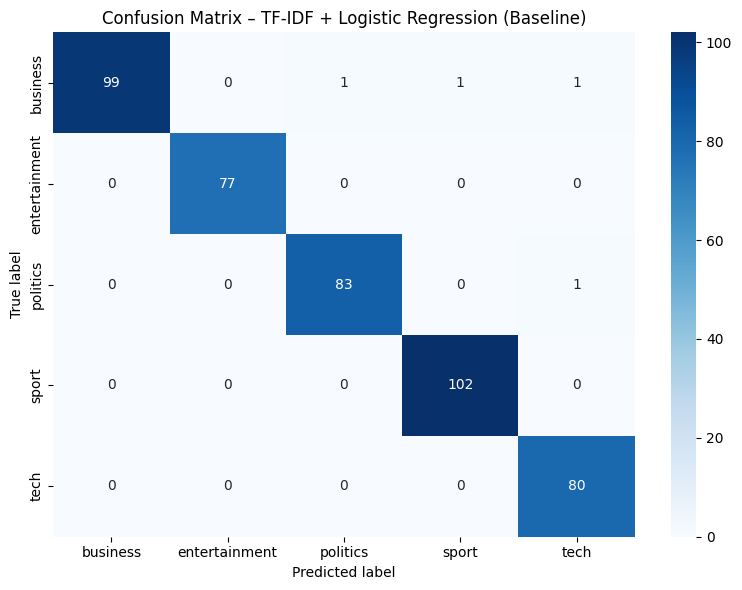

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels_sorted = sorted(df["label"].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – TF-IDF + Logistic Regression (Baseline)")
plt.tight_layout()
plt.show()


Normalisierte Confusion Matrix

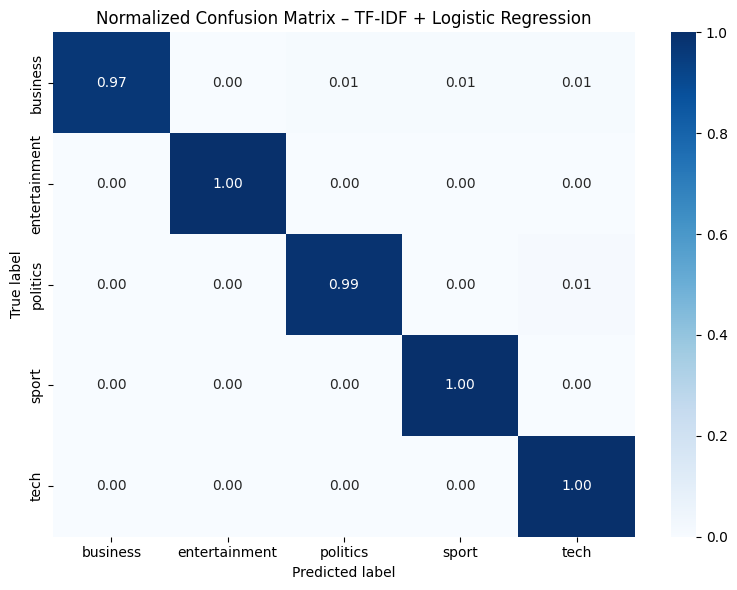

In [11]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – TF-IDF + Logistic Regression")
plt.tight_layout()
plt.show()


In [12]:
# Zeilensummen prüfen (sollte immer 1.0 sein)
print("Zeilensummen (sollte überall 1.0 sein):")
print(cm_norm.sum(axis=1))
print("\nDiagonalwerte (= Recall pro Klasse):")
for i, label in enumerate(labels_sorted):
    print(f"{label}: {cm_norm[i, i]:.2%}")

Zeilensummen (sollte überall 1.0 sein):
[1. 1. 1. 1. 1.]

Diagonalwerte (= Recall pro Klasse):
business: 97.06%
entertainment: 100.00%
politics: 98.81%
sport: 100.00%
tech: 100.00%


Plot speichern

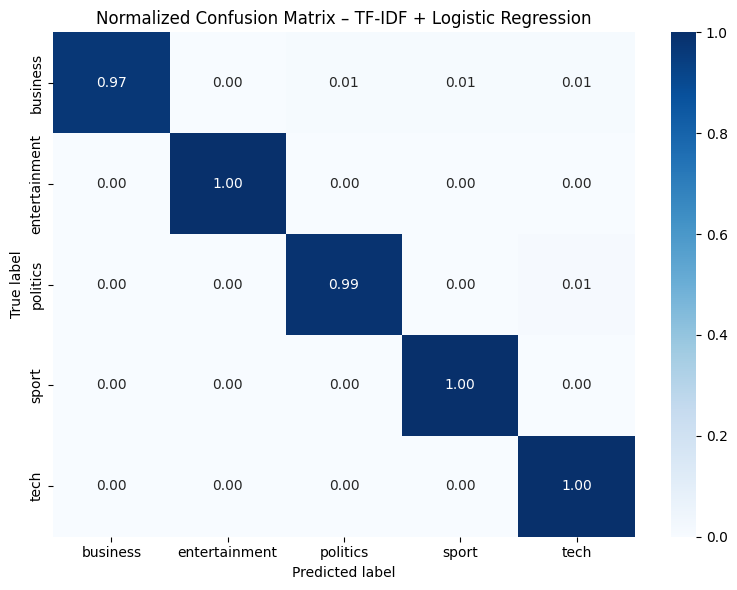

Saved to: c:\CAS\cas-ml-document-classification\results\baseline_confusion_matrix.png


In [13]:
fig_path = PROJECT_ROOT / "results" / "baseline_confusion_matrix.png"
fig_path.parent.mkdir(exist_ok=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – TF-IDF + Logistic Regression")
plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()

print("Saved to:", fig_path)


## 5) Fehlklassifikationen anschauen (Error Analysis)


In [11]:
results = pd.DataFrame({
    "true": y_test.values,
    "pred": y_pred,
    "text": X_test.values
})

errors = results[results["true"] != results["pred"]].copy()
print("Fehler:", len(errors), "von", len(results))
errors.head(10)


Fehler: 4 von 445


,true,pred,text
214,politics,tech,UK firms 'embracing e-commerce'\n\nUK firms ar...
243,business,politics,Golden rule 'intact' says ex-aide\n\nChancello...
256,business,tech,BT offers equal access to rivals\n\nBT has mov...
295,business,sport,Arsenal 'may seek full share listing'\n\nArsen...


Gibt es Daten Leakage?

In [12]:
train_texts = set(X_train)
test_texts = set(X_test)

len(train_texts.intersection(test_texts))


33

In [13]:
y_train.value_counts(normalize=True).round(3)


label
sport            0.230
business         0.229
politics         0.187
tech             0.180
entertainment    0.174
Name: proportion, dtype: float64

## Weitere Validierungschecks

Um sicherzustellen, dass die hohe Accuracy legitim ist:

In [14]:
# 1. Cross-Validation für robustere Schätzung
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(baseline_clf, X, y, cv=5, scoring='accuracy')
print("5-Fold Cross-Validation Scores:", cv_scores.round(3))
print("Mean CV Accuracy:", cv_scores.mean().round(4), "±", cv_scores.std().round(4))

5-Fold Cross-Validation Scores: [0.964 0.971 0.942 0.982 0.987]
Mean CV Accuracy: 0.969 ± 0.0159


In [15]:
# 2. Top-Features pro Klasse anschauen
# Zeigt, ob das Modell sinnvolle Wörter lernt

vectorizer = baseline_clf.named_steps["tfidf"]
logreg = baseline_clf.named_steps["logreg"]

feature_names = vectorizer.get_feature_names_out()

print("Top 10 Features pro Klasse:\n")
for i, label in enumerate(sorted(df["label"].unique())):
    # Koeffizienten für diese Klasse
    coefs = logreg.coef_[i]
    top_indices = coefs.argsort()[-10:][::-1]
    top_features = [feature_names[idx] for idx in top_indices]
    print(f"{label:15s}: {', '.join(top_features)}")

Top 10 Features pro Klasse:

business       : bank, shares, economy, company, growth, firm, market, oil, economic, sales
entertainment  : film, music, band, album, singer, tv, festival, star, award, best
politics       : mr, labour, party, government, election, blair, said, minister, secretary, lord
sport          : match, cup, win, club, england, injury, season, team, game, coach
tech           : software, technology, computer, users, mobile, online, people, games, net, digital


In [16]:
# 3. Prüfe, ob es verdächtig einfache Patterns gibt
# (z.B. alle Sport-Artikel enthalten "football" oder ähnliches)

print("Wie oft kommt jede Klasse überhaupt im Test-Set vor?")
print(y_test.value_counts().sort_index())

# Check: Gibt es einzelne Wörter, die fast perfekt eine Klasse vorhersagen?
print("\n\nPrüfe auf zu einfache Patterns...")

Wie oft kommt jede Klasse überhaupt im Test-Set vor?
label
business         102
entertainment     77
politics          84
sport            102
tech              80
Name: count, dtype: int64


Prüfe auf zu einfache Patterns...
